In [1]:
# Import Python SQL toolkit and Object Relational Mapper, and other dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import matplotlib
#matplotlib.use('nbagg') TO DELETE
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
#Create engine for "hawaii.sqlite" db file
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [4]:
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [5]:
# Create the inspector and connect it to the engine
# Also get names of tables in the db
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [6]:
# Reflect Database into ORM classes (Station and Measurement)
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.stations
Measurement = Base.classes.measurements

In [7]:
session = Session(engine)

## Precipitation Analysis

In [8]:
#Design a query to retrieve the last 12 months of precipitation data.

# First, get the most recent date
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
    
print(last_date)

('2017-08-23',)


In [9]:
# Most recent date in the table is 2017-08-23, so need to get previous 12 months (365 days)
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)  
print(query_date)


2016-08-23


In [10]:
# Query for last 12 months of precipitation data
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all()
    

In [25]:
# Create dataframe from the query data (set index to 'date')
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index('date')
prcp_df.head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


In [26]:
# Plot the results in a Matplotlib bar chart (TO FINISH)

prcp_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Precipitation Analysis - Last 12 Months")
plt.legend(["precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: 'date'

In [37]:
# Use Pandas to print the summary statistics for the precipitation data
## using describe command

prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [59]:
#Design a query to calculate the total number of stations
session.query(func.count(Station.station)).all() 

[(9)]

In [77]:
# Design a query to find the most active stations.
## List the stations and observation counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [80]:
## Which station has the highest number of observations?
session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()

('USC00519281')

In [23]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
## Filter by the station with the highest number of observations.
station_data = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
    filter(Measurement.date > query_date, Measurement.station == "USC00519281" ).\
    group_by(Measurement.tobs).\
    order_by(Measurement.tobs.desc()).all()


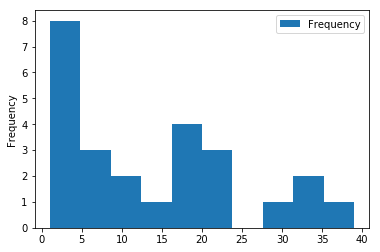

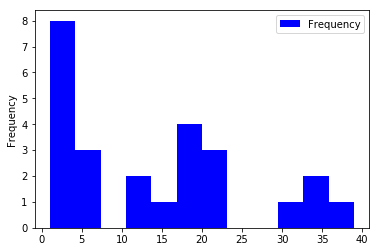

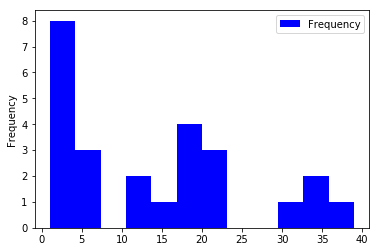

In [27]:
## Plot the results as a histogram with bins=12.
df_station = pd.DataFrame(station_data, columns=['tobs', 'Frequency'])
df_station.set_index('tobs', inplace=True)
df_station.plot.hist(bins=12, histtype='bar', align='mid', orientation='vertical', color="Blue")
plt.show()



## Temperature Analysis

In [ ]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d
# and return the minimum, average, and maximum temperatures for that range of dates.

def calc_temps(start_date, end_date):
        session.query(Measurement.)